<a href="https://colab.research.google.com/github/wnourse05/SNS-Toolbox-and-SNSTorch-Tutorial/blob/main/NICE_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# NICE 2024: SNS-Toolbox and SNSTorch
Based on tutorials and documentation available at [https://sns-toolbox.readthedocs.io/en/latest/index.html](https://sns-toolbox.readthedocs.io/en/latest/index.html)

Install the required python packages (sns-toolbox, snstorch, mujoco). This may take a little bit...

In [1]:
!pip install sns-toolbox
!pip install snstorch
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess

# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

from IPython.display import clear_output
clear_output()


# SNS-Toolbox
## 1. Designing a Basic Nonspiking Network

The first step is importing the necessary packages.

In [3]:
import sns_toolbox
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.networks import Network
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.renderer import render

In SNS-Toolbox, we have to define neuron and synapse types before we can use them. Let's start with a basic non-spiking leaky integrator.

In [ ]:
neuron_type = NonSpikingNeuron(name='Neuron',  # Name displayed in a render of the network
                               color='white',  # Fill color for the rendered neuron
                               membrane_capacitance=5.0,  # Membrane capacitance in nF
                               membrane_conductance=1.0,  # Membrane conductance in uS
                               bias=0.0)                # Tonic applied current in nA

Next, let's define three different chemical synapses: one excitatory, one inhibitory, and one modulatory/shunting.

In [ ]:
"""
Define some synapse types
"""
synapse_excitatory = NonSpikingSynapse(max_conductance=1.0, reversal_potential=50.0) # make an excitatory synapse
synapse_inhibitory = NonSpikingSynapse(max_conductance=1.0, reversal_potential=-40.0) # make an inhibitory synapse
# Define a modulatory synapse (relative reversal potential is 0)
synapse_modulatory = NonSpikingSynapse(max_conductance=1.0, reversal_potential=0.0)

We have defined neuron and synapse types, but we have nowhere to put them. Let's initialize a Network, which acts as the container that stores our network parameters and connectivity.

In [ ]:
net0 = Network()

Now, using our preexisting types, we can start adding neurons and synapses into the network. Let's make a basic excitatory pathway, with a source neuron exciting a postsynaptic neuron.

In [ ]:
# Make a neuron to receive external input
net0.add_neuron(neuron_type, name='SourceNrn', color='black')

# Make a neuron which is excited by the source neuron
net0.add_neuron(neuron_type, name='Dest1', color='blue')
net0.add_connection(synapse_excitatory, 'SourceNrn', 'Dest1')

In order to visualize neural designs, SNS-Toolbox comes with a builtin interface with graphviz. Let's use the renderer to render a graph of this (relatively simple) network.

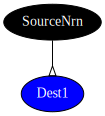

In [ ]:
render(net0) # Display the network graph in this notebook

Let's add two more neurons. One is excited by the source and excites the other, the other inhibits the first.

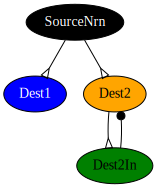

In [ ]:
net0.add_neuron(neuron_type, name='Dest2', color='orange')
net0.add_neuron(neuron_type, name='Dest2In', color='green')
net0.add_connection(synapse_excitatory, 'SourceNrn', 'Dest2')
net0.add_connection(synapse_excitatory, 'Dest2', 'Dest2In')
net0.add_connection(synapse_inhibitory, 'Dest2In', 'Dest2')

render(net0)

We make one more neuron, which will be excited by the source neuron and modulated by Dest1.

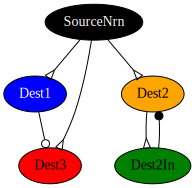

In [ ]:
net0.add_neuron(neuron_type, name='Dest3', color='red')
net0.add_connection(synapse_excitatory, 'SourceNrn', 'Dest3')
net0.add_connection(synapse_modulatory, 'Dest1', 'Dest3')

render(net0)

Now we need to add an input source, so that during simulation we can apply an external stimulus to the source neuron.

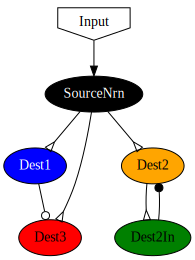

In [ ]:
net0.add_input(dest='SourceNrn', name='Input', color='white')

render(net0)

Finally we add output monitors, so that we can view the state of each neuron in the network.

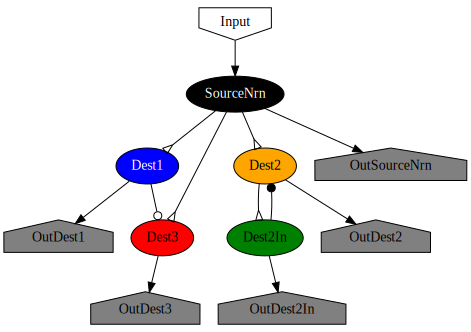

In [ ]:
net0.add_output('SourceNrn', name='OutSourceNrn', color='grey')
net0.add_output('Dest1', name='OutDest1', color='grey')
net0.add_output('Dest2', name='OutDest2', color='grey')
net0.add_output('Dest2In', name='OutDest2In', color='grey')
net0.add_output('Dest3', name='OutDest3', color='grey')

render(net0)

## 2. Compiling and Simulating a Basic Network
Now that we have built a description of our network, we need to compile it to the backend of our choice and simulate it. In our case we will be compiling to a `numpy` representation.

First, we start by setting some general parameters for the simulation.

In [ ]:
# Set simulation parameters
dt = 0.01 # Simulation timestep in ms
t_max = 50 # Max simulation time in ms

# Initialize a vector of timesteps
t = np.arange(0, t_max, dt)

# Initialize vectors which store the input to our network, and for data to be written to during simulation from outputs
inputs = np.zeros([len(t),1])+20.0  # Input vector must be 2d, even if second dimension is 1
data = np.zeros([len(t),5])

Next we compile the network. We pass in the network blueprint, our timestep, and an optional `debug` flag (if you want to see the individual steps in the compilation process, set `debug` to `True`).

In [ ]:
model = net0.compile(backend='numpy', dt=dt, debug=False)
# Note that if you want to compile to the GPU, you would need to use the "torch" backend
# model = net0.compile(backend='torch', dt=dt, device='cuda')

Now we can simulate the network. We create a loop, and at every timestep we apply the current input to a forward pass of the network. At each step we also store the results in `data`.

In [ ]:
for i in range(len(t)):
    data[i,:] = model(inputs[i,:])

Let's plot the results of our simulation.

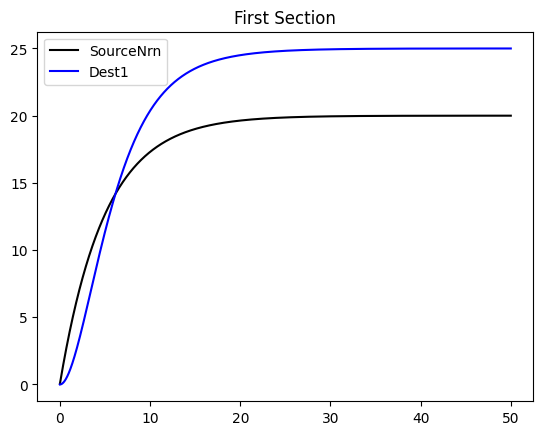

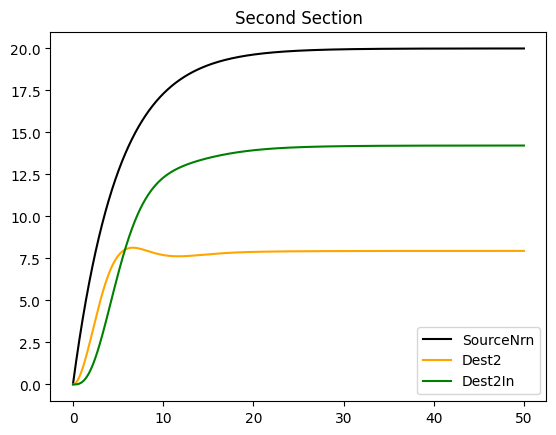

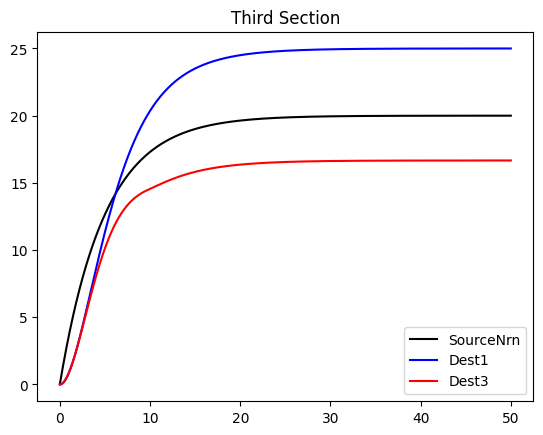

In [ ]:
data = data.transpose() # Rearrange the data axes for easier plotting

"""Plot the data"""
# First section
plt.figure()
plt.title('First Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')  # When plotting, all data needs to be transposed first
plt.plot(t,data[:][1],label='Dest1',color='blue')
plt.legend()

# Second section
plt.figure()
plt.title('Second Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')
plt.plot(t,data[:][2],label='Dest2',color='orange')
plt.plot(t,data[:][3],label='Dest2In',color='green')
plt.legend()

# Third section
plt.figure()
plt.title('Third Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')
plt.plot(t,data[:][1],label='Dest1',color='blue')
plt.plot(t,data[:][4],label='Dest3',color='red')
plt.legend()

plt.show()  # Show the plots

## 3. Spiking Networks
Up to this point we’ve created networks of neurons and synapses which only operate in the non-spiking regime. Now, we will create a network of spiking neurons and populations, and record activity with spike monitors.

In [ ]:
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.plot_utilities import spike_raster_plot # This module is necessary for plotting spike rasters

Let's make a spiking network where each neuron has a different threshold proportionality constant `m`.

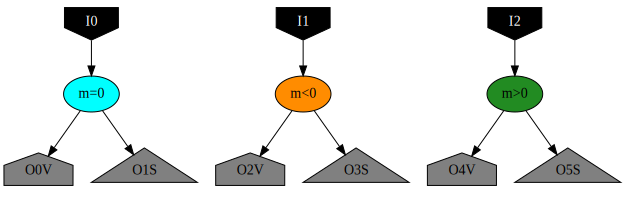

In [ ]:
# Create spiking neurons with different values of 'm'
threshold_initial_value = 1.0
spike_m_equal_0 = SpikingNeuron(name='m = 0', color='aqua',
                                threshold_time_constant=5.0,  # Default value of tau_m (ms)
                                threshold_proportionality_constant=0.0,  # Default value of m
                                threshold_initial_value=threshold_initial_value)  # Default value of theta_0 (mV)
spike_m_less_0 = SpikingNeuron(name='m < 0', color='darkorange',
                               threshold_proportionality_constant=-1.0)
spike_m_greater_0 = SpikingNeuron(name='m > 0', color='forestgreen',
                                  threshold_proportionality_constant=1.0)

# Create a spiking synapse
synapse_spike = SpikingSynapse(time_constant=1.0)    # Default value (ms)

# Create a network with different m values
net1 = Network()
net1.add_neuron(spike_m_equal_0, name='m=0')
net1.add_neuron(spike_m_less_0, name='m<0')
net1.add_neuron(spike_m_greater_0, name='m>0')

# Add an input current source
net1.add_input(dest='m=0', name='I0', color='black')
net1.add_input(dest='m<0', name='I1', color='black')
net1.add_input(dest='m>0', name='I2', color='black')

# Add output monitors (some for the voltage, some for the spikes)
net1.add_output('m=0', name='O0V', color='grey')
net1.add_output('m=0', name='O1S', color='grey', spiking=True)  # Records spikes instead of voltage
net1.add_output('m<0', name='O2V', color='grey')
net1.add_output('m<0', name='O3S', color='grey', spiking=True)  # Records spikes instead of voltage
net1.add_output('m>0', name='O4V', color='grey')
net1.add_output('m>0', name='O5S', color='grey', spiking=True)  # Records spikes instead of voltage

render(net1)

Again, we can compile and simulate the network

In [ ]:
dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
inputs = np.zeros([len(t), net1.get_num_inputs()]) + 20      # getNumInputs() gets the number of input nodes in a network
data = np.zeros([len(t), net1.get_num_outputs_actual()])    # getNumOutputsActual gets the number of accessible output
                                                            # nodes in a network (since this net has populations, each
                                                            # population has n output nodes)
# Compile to numpy
model1 = net1.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model1(inputs[i,:])
data = data.transpose()

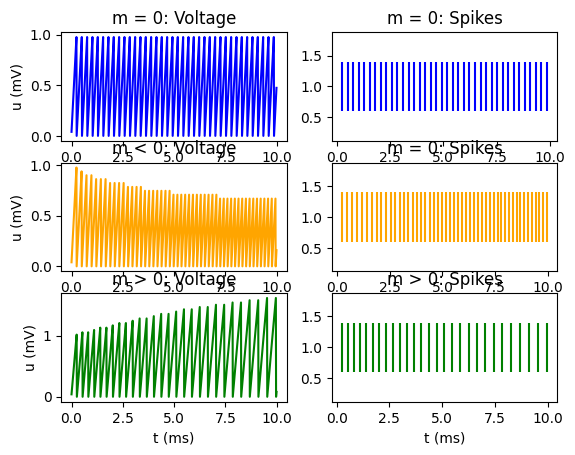

In [ ]:
plt.figure()
plt.subplot(3,2,1)
plt.title('m = 0: Voltage')
plt.plot(t,data[:][0],color='blue')
# plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,2)
plt.title('m = 0: Spikes')
spike_raster_plot(t, data[:][1],colors=['blue'])
# plt.xlabel('t (ms)')
plt.subplot(3,2,3)
plt.title('m < 0: Voltage')
plt.plot(t,data[:][2],color='orange')
# plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,4)
plt.title('m = 0: Spikes')
spike_raster_plot(t, data[:][3],colors=['orange'])
# plt.xlabel('t (ms)')
plt.subplot(3,2,5)
plt.title('m > 0: Voltage')
plt.plot(t,data[:][4],color='green')
plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,6)
plt.title('m > 0: Spikes')
spike_raster_plot(t, data[:][5],colors=['green'])
plt.xlabel('t (ms)')

plt.show()

So far we have been adding neurons to our networks individually. However, we can also add neurons in larger populations as well.

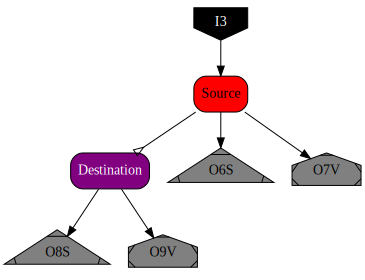

In [ ]:
pop_size = 5
net2 = Network()
initial_values = np.linspace(0.0,threshold_initial_value,num=pop_size)
net2.add_population(spike_m_equal_0, shape=[pop_size], color='red', name='Source',initial_value=initial_values)
net2.add_population(spike_m_equal_0, shape=[pop_size], color='purple', name='Destination',initial_value=initial_values)
net2.add_input(dest='Source', name='I3', color='black')
net2.add_connection(synapse_spike, 'Source', 'Destination')
net2.add_output('Source', name='O6S', color='grey', spiking=True)
net2.add_output('Source', name='O7V', color='grey', spiking=False)
net2.add_output('Destination', name='O8S', color='grey', spiking=True)
net2.add_output('Destination', name='O9V', color='grey', spiking=False)

render(net2)

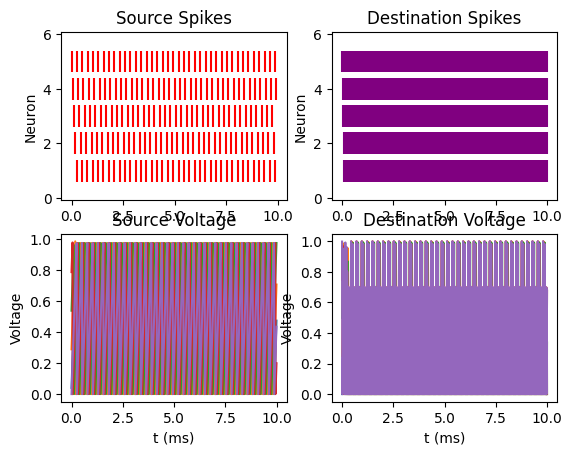

In [ ]:
dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
inputs = np.zeros([len(t), net2.get_num_inputs()]) + 20      # getNumInputs() gets the number of input nodes in a network
data = np.zeros([len(t), net2.get_num_outputs_actual()])    # getNumOutputsActual gets the number of accessible output
                                                            # nodes in a network (since this net has populations, each
                                                            # population has n output nodes)
# Compile to numpy
model2 = net2.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model2(inputs[i,:])
data = data.transpose()

plt.figure()
plt.subplot(2,2,1)
spike_raster_plot(t,data[:][:pop_size],colors=['red'])
plt.ylabel('Neuron')
plt.title('Source Spikes')
plt.subplot(2, 2, 2)
spike_raster_plot(t,data[:][2*pop_size:3*pop_size],colors=['purple'])
plt.ylabel('Neuron')
plt.title('Destination Spikes')
plt.subplot(2,2,3)
for i in range(pop_size):
    plt.plot(t,data[:][pop_size+i])
plt.xlabel('t (ms)')
plt.ylabel('Voltage')
plt.title('Source Voltage')
plt.subplot(2, 2, 4)
for i in range(pop_size):
    plt.plot(t,data[:][3*pop_size+i])
plt.xlabel('t (ms)')
plt.ylabel('Voltage')
plt.title('Destination Voltage')

plt.show()

## 4. Combining Networks
As we make larger networks, it can be practical to assemble networks using smaller subnetworks. To demonstrate, let's merge the previous 2 networks into one compiled model.

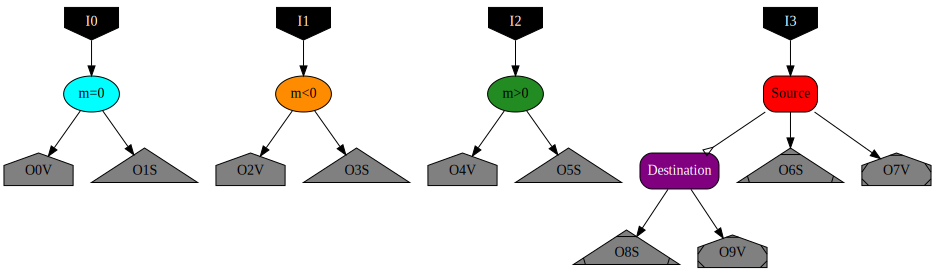

In [ ]:
net3 = Network()
net3.add_network(net1)
net3.add_network(net2)

render(net3)

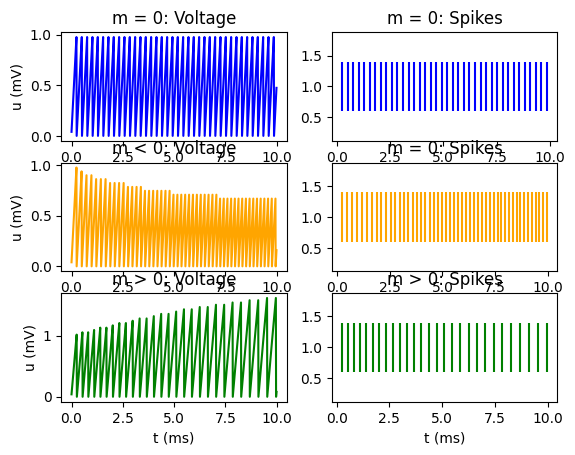

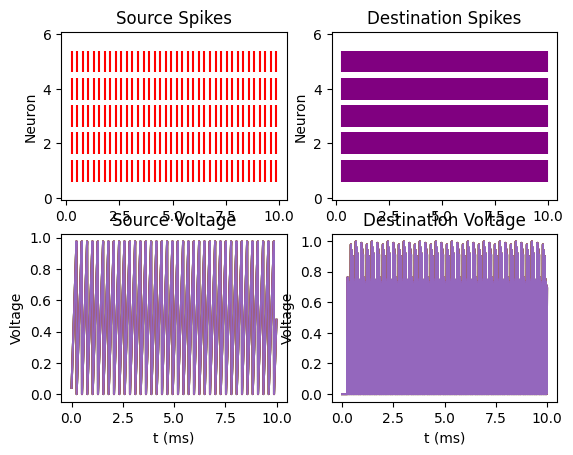

In [ ]:
dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
inputs = np.zeros([len(t), net3.get_num_inputs()]) + 20      # getNumInputs() gets the number of input nodes in a network
data = np.zeros([len(t), net3.get_num_outputs_actual()])    # getNumOutputsActual gets the number of accessible output
                                                            # nodes in a network (since this net has populations, each
                                                            # population has n output nodes)
# Compile to numpy
model3 = net3.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model3(inputs[i,:])
data = data.transpose()
plt.figure()
plt.subplot(3,2,1)
plt.title('m = 0: Voltage')
plt.plot(t,data[:][0],color='blue')
# plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,2)
plt.title('m = 0: Spikes')
spike_raster_plot(t, data[:][1],colors=['blue'])
# plt.xlabel('t (ms)')
plt.subplot(3,2,3)
plt.title('m < 0: Voltage')
plt.plot(t,data[:][2],color='orange')
# plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,4)
plt.title('m = 0: Spikes')
spike_raster_plot(t, data[:][3],colors=['orange'])
# plt.xlabel('t (ms)')
plt.subplot(3,2,5)
plt.title('m > 0: Voltage')
plt.plot(t,data[:][4],color='green')
plt.xlabel('t (ms)')
plt.ylabel('u (mV)')
plt.subplot(3,2,6)
plt.title('m > 0: Spikes')
spike_raster_plot(t, data[:][5],colors=['green'])
plt.xlabel('t (ms)')
plt.figure()
plt.subplot(2,2,1)
spike_raster_plot(t,data[:][6:6+pop_size],colors=['red'])
plt.ylabel('Neuron')
plt.title('Source Spikes')
plt.subplot(2, 2, 2)
spike_raster_plot(t,data[:][6+2*pop_size:6+3*pop_size],colors=['purple'])
plt.ylabel('Neuron')
plt.title('Destination Spikes')
plt.subplot(2,2,3)
for i in range(pop_size):
    plt.plot(t,data[:][6+pop_size+i])
plt.xlabel('t (ms)')
plt.ylabel('Voltage')
plt.title('Source Voltage')
plt.subplot(2, 2, 4)
for i in range(pop_size):
    plt.plot(t,data[:][6+3*pop_size+i])
plt.xlabel('t (ms)')
plt.ylabel('Voltage')
plt.title('Destination Voltage')

plt.show()

## 5. Advanced Spiking and Propagation Delay
Based on feedback from our users, in version 1.5.0 of SNS-Toolbox we expanded our model of Spiking Neurons and Synapses. The new spiking models are fully backwards compatible with the original spiking model in SNS-Toolbox, so neurons and synapses which are initialized using only the old parameters will behave as expected.

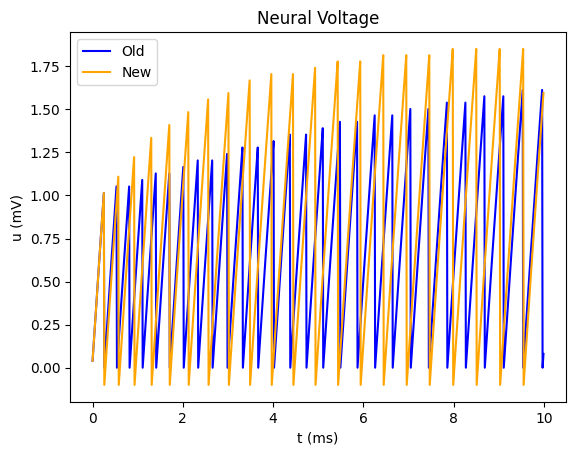

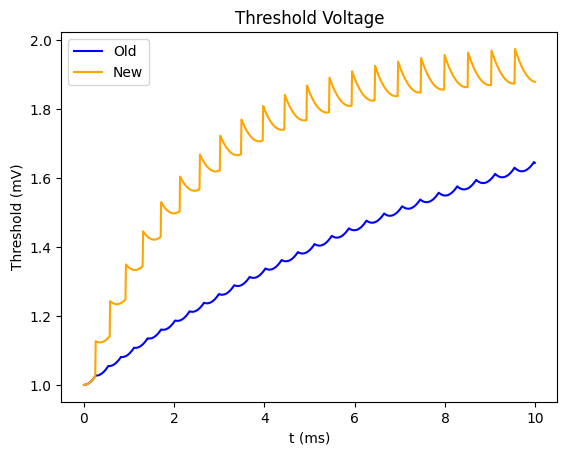

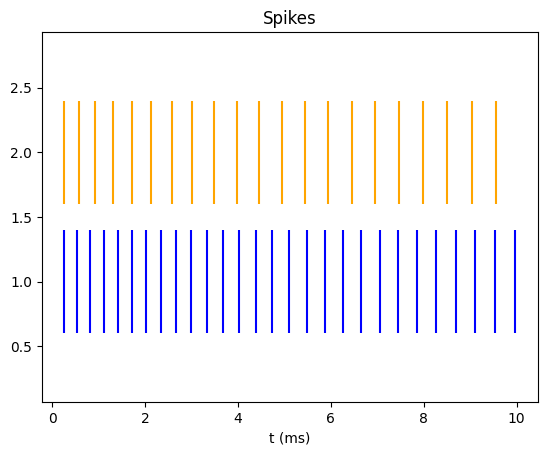

In [ ]:
type_neuron_spiking_old = SpikingNeuron(threshold_time_constant=5.0,
                                        threshold_initial_value=1.0,
                                        threshold_proportionality_constant=1.0,
                                        bias=20.0)
type_neuron_spiking_new = SpikingNeuron(threshold_time_constant=5.0,
                                        threshold_initial_value=1.0,
                                        threshold_proportionality_constant=1.0,
                                        bias=20.0,
                                        threshold_leak_rate=2.0,    # New in v1.5.0
                                        threshold_floor=0.0,        # New in v1.5.0
                                        reset_potential=-0.1,       # New in v1.5.0
                                        threshold_increment=0.1)    # New in v1.5.0
net = Network()
net.add_neuron(type_neuron_spiking_old,'Old')
net.add_neuron(type_neuron_spiking_new, 'New')

net.add_output('Old')
net.add_output('New')
net.add_output('Old',spiking=True)
net.add_output('New', spiking=True)

dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
data = np.zeros([len(t), net.get_num_outputs_actual()])
thresholds = np.zeros([len(t), 2])
# Compile to numpy
model = net.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model()
    thresholds[i,:] = model.theta
data = data.transpose()
thresholds = thresholds.transpose()

"""Plotting the results"""
plt.figure()
plt.plot(t,data[:][0], color='blue', label='Old')
plt.plot(t,data[:][1], color='orange', label='New')
plt.title('Neural Voltage')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('u (mV)')

plt.figure()
plt.plot(t,thresholds[:][0], color='blue', label='Old')
plt.plot(t,thresholds[:][1], color='orange', label='New')
plt.title('Threshold Voltage')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Threshold (mV)')

plt.figure()
plt.title('Spikes')
spike_raster_plot(t, data[:][2:4],colors=['blue','orange'])
plt.xlabel('t (ms)')
plt.show()

For spiking synapses, we added a conductance increment factor. Previously all spiking synapses reset to a maximum value whenever the presynaptic neuron fired, now they can increment by a specified interval while being constrained by an upper bound.

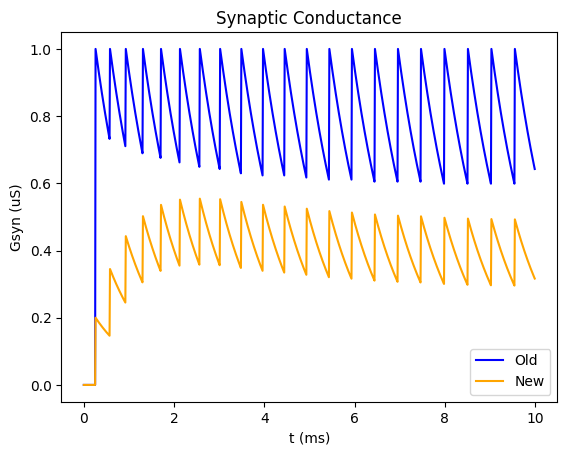

In [ ]:
net2 = Network()
net2.add_neuron(type_neuron_spiking_new,'Pre')
net2.add_neuron(type_neuron_spiking_new, 'PostOld')
net2.add_neuron(type_neuron_spiking_new, 'PostNew')

synapse_old = SpikingSynapse(max_conductance=1.0,
                             reversal_potential=194.0,
                             time_constant=1.0,
                             transmission_delay=0)
synapse_new = SpikingSynapse(max_conductance=1.0,
                             reversal_potential=194.0,
                             time_constant=1.0,
                             transmission_delay=0,
                             conductance_increment=0.2) # New in v1.5.0
net2.add_connection(synapse_old,'Pre', 'PostOld')
net2.add_connection(synapse_new, 'Pre', 'PostNew')

g_syn = np.zeros([len(t), 2])
# Compile to numpy
model2 = net2.compile(backend='numpy', dt=dt, debug=False)

for i in range(len(t)):
    model2()
    g_syn[i,0] = model2.g_spike[1,0]
    g_syn[i,1] = model2.g_spike[2,0]
g_syn = g_syn.transpose()

plt.figure()
plt.plot(t,g_syn[:][0], color='blue', label='Old')
plt.plot(t,g_syn[:][1], color='orange', label='New')
plt.title('Synaptic Conductance')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Gsyn (uS)')

plt.show()

Spiking synapses can also use propagation delay, in order to enable some types of temporal processing networks.

In [ ]:
"""Define our types"""
neuron_type = SpikingNeuron()
synapse_type_d0 = SpikingSynapse(transmission_delay=0)   # Transmission delay of 0 dt
synapse_type_d5 = SpikingSynapse(transmission_delay=5)   # Transmission delay of 5 dt
synapse_type_d10 = SpikingSynapse(transmission_delay=10)   # Transmission delay of 10 dt
synapse_type_d20 = SpikingSynapse(transmission_delay=20)   # Transmission delay of 20 dt

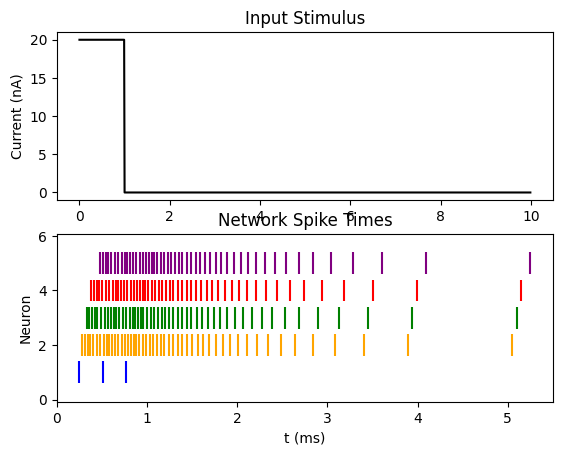

In [ ]:
"""Create our network"""
net = Network(name='Tutorial 5 Network')

net.add_neuron(neuron_type, name='Source', color='blue')
net.add_neuron(neuron_type, name='D0', color='orange')
net.add_neuron(neuron_type, name='D5', color='green')
net.add_neuron(neuron_type, name='D10', color='red')
net.add_neuron(neuron_type, name='D20', color='purple')

net.add_connection(synapse_type_d0, 'Source', 'D0')
net.add_connection(synapse_type_d5, 'Source', 'D5')
net.add_connection(synapse_type_d10, 'Source', 'D10')
net.add_connection(synapse_type_d20, 'Source', 'D20')

net.add_output('Source', name='OSS', spiking=True)
net.add_output('D0', name='O0S', spiking=True)
net.add_output('D5', name='O5S', spiking=True)
net.add_output('D10', name='O10S', spiking=True)
net.add_output('D20', name='O20S', spiking=True)

net.add_input('Source')

render(net)

"""Simulate the network"""
dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
inputs = np.zeros([len(t), net.get_num_inputs()])          # getNumInputs() gets the number of input nodes in a network
inputs[0:100] = 20.0
data = np.zeros([len(t), net.get_num_outputs_actual()])    # getNumOutputsActual gets the number of accessible output
                                                            # nodes in a network (since this net has populations, each
                                                            # population has n output nodes)
# Compile to numpy
model = net.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model(inputs[i,:])
data = data.transpose()

"""Plotting the results"""
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,inputs,color='black')
plt.title('Input Stimulus')
plt.ylabel('Current (nA)')
plt.subplot(2,1,2)
spike_raster_plot(t,data[:][:],colors=['blue','orange','green','red','purple'])
plt.title('Network Spike Times')
plt.ylabel('Neuron')
plt.xlabel('t (ms)')


plt.show()

## 6. Connectivity Patterns
Let's start looking at larger networks. As networks get larger and larger, it may be ideal to describe connections as connectivity patterns/kernels instead of individual synapses. In this example, we implement a basic convolutional-type pattern.

(-0.5, 31.5, 31.5, -0.5)

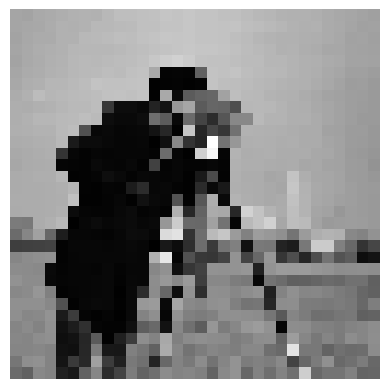

In [ ]:
import cv2 as cv
img = cv.imread('/content/cameraman.jpg')   # load image file

shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.figure()
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

We can make a simple two-layer network, which is loosely inspired by some of the computations happening in the insect visual nervous system.

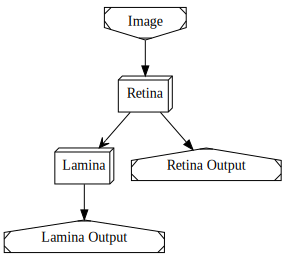

In [ ]:
from sns_toolbox.connections import NonSpikingPatternConnection
# General network
R = 20.0    # range of network activity (mV)
neuron_type = NonSpikingNeuron()    # generic neuron type
net = Network(name='Visual Network')    # create an empty network

# Retina
net.add_population(neuron_type,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

# Lamina
net.add_population(neuron_type,shape,name='Lamina')

del_e_ex = 160.0    # excitatory reversal potential
del_e_in = -80.0    # inhibitory reversal potential
k_ex = 1.0  # excitatory gain
k_in = -1.0/9.0 # inhibitory gain
g_max_ex = (k_ex*R)/(del_e_ex-k_ex*R)   # calculate excitatory conductance
g_max_in = (k_in*R)/(del_e_in-k_in*R)   # calculate inhibitory conductance

g_max_kernel = np.array([[g_max_in, g_max_in, g_max_in],    # kernel matrix of synaptic conductances
                         [g_max_in, g_max_ex, g_max_in],
                         [g_max_in, g_max_in, g_max_in]])
del_e_kernel = np.array([[del_e_in, del_e_in, del_e_in],    # kernel matrix of synaptic reversal potentials
                         [del_e_in, del_e_ex, del_e_in],
                         [del_e_in, del_e_in, del_e_in]])
e_lo_kernel = np.zeros([3,3])
e_hi_kernel = np.zeros([3,3]) + R
connection_hpf = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_hpf,'Retina','Lamina',name='HPF') # connect the retina to the lamina
net.add_output('Lamina',name='Lamina Output')  # add a vector output from the lamina

img_flat = img_flat*R/255.0 # scale all the intensities from 0-255 to 0-R
render(net)

1 / 3 steps
2 / 3 steps
3 / 3 steps


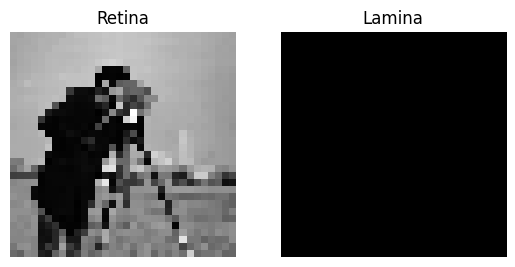

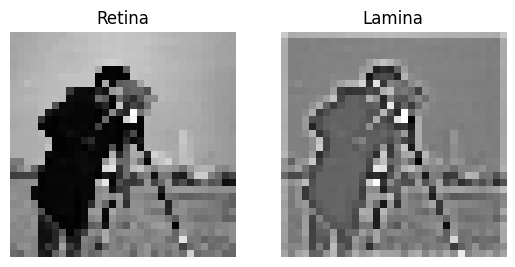

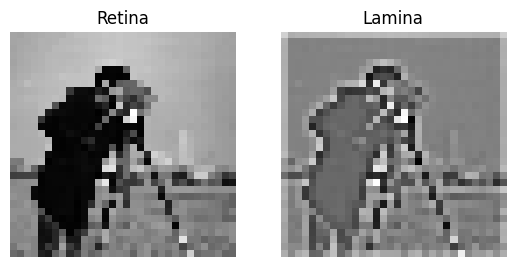

In [ ]:
dt = neuron_type.params['membrane_capacitance']/neuron_type.params['membrane_conductance']  # calculate the ideal dt
t_max = 15  # run for 15 ms
steps = int(t_max/dt)   # number of steps to simulate

model = net.compile(backend='numpy',dt=dt,debug=False) # compile using the numpy backend
for i in range(steps):
    print('%i / %i steps'%(i+1,steps))
    plt.figure()    # create a figure for live plotting the retina and lamina states
    plt.subplot(1,2,1)
    plt.title('Retina')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Lamina')
    plt.axis('off')

    out = model(img_flat)   # run the network for one dt
    retina = out[:flat_size]    # separate the retina and lamina states
    lamina = out[flat_size:]
    retina_reshape = np.reshape(retina,shape)   # reshape to from flat to an image
    lamina_reshape = np.reshape(lamina,shape)
    plt.subplot(1,2,1)  # plot the current state
    plt.imshow(retina_reshape,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(lamina_reshape, cmap='gray')

## 7. Putting it all Together

Let's use what we've covered so far and control an external system. We will make a controller for hexapod locomotion, based on a (very simplified) model of the insect nervous system.

First, we need to load in the model we want to control in Mujoco.

In [4]:
import mujoco
import mujoco.viewer
XML=r"""
<mujoco model="hexapod">
  <compiler angle="degree" coordinate="local" inertiafromgeom="true"/>
  <option integrator="RK4" timestep="0.01"/>
  <custom>
    <numeric data="0.0 0.0 0.55 1.0 0.0 0.0 0.0 0.0 1.0 0.0 -1.0 0.0 -1.0 0.0 1.0" name="init_qpos"/>
  </custom>
  <default>
    <joint armature="1" damping="1" limited="true"/>
    <geom conaffinity="0" condim="3" density="5.0" friction="1 0.5 0.5" margin="0.01" rgba="0.8 0.6 0.4 1"/>
  </default>
  <asset>
    <texture builtin="gradient" height="100" rgb1="1 1 1" rgb2="0 0 0" type="skybox" width="100"/>
    <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
    <texture builtin="checker" height="100" name="texplane" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d" width="100"/>
    <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
    <material name="geom" texture="texgeom" texuniform="true"/>
  </asset>
  <worldbody>
    <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
    <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="40 40 40" type="plane"/>
    <body name="torso" pos="0 0 0.75">
      <camera name="track" mode="trackcom" pos="0 -3 0.3" xyaxes="1 0 0 0 0 1"/>
      <geom name="torso_geom" fromto="-1.0 0.0 0.0 1.0 0.0 0.0" size="0.15" type="capsule" density="100"/>
      <joint armature="0" axis="1 0 0" damping="0" limited="false" name="rootx" pos="0 0 0" stiffness="0" type="slide"/>
      <joint armature="0" axis="0 0 1" damping="0" limited="false" name="rootz" pos="0 0 0" stiffness="0" type="slide"/>
      <joint armature="0" axis="0 1 0" damping="0" limited="false" name="rooty" pos="0 0 0" stiffness="0" type="hinge"/>
      <body name="front_left_leg" pos="-0.9 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 -0.2 0.0" name="aux_0_geom" size="0.08" type="capsule"/>
        <body name="aux_0" pos="0.0 -0.2 0">
          <joint axis="0 0 -1" name="hip_0" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 -0.3 0.0" name="front_left_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 -0.3 0">
            <joint axis="-1 0 0" name="knee_0" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 -0.5 0.0" name="front_left_ankle_geom" size="0.08" type="capsule"/>
            <site name="foot_0" type="capsule" fromto="0.0 0.0 0.0 0.0 -0.5 0.0" rgba="0.8 0.6 0.4 0" size="0.1"/>
          </body>
        </body>
      </body>
      <body name="center_left_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 -0.2 0.0" name="aux_1_geom" size="0.08" type="capsule"/>
        <body name="aux_1" pos="0.0 -0.2 0">
          <joint axis="0 0 -1" name="hip_1" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 -0.3 0.0" name="center_left_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 -0.3 0">
            <joint axis="-1 0 0" name="knee_1" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 -0.5 0.0" name="center_left_ankle_geom" size="0.08" type="capsule"/>
            <site name="foot_1" type="capsule" fromto="0.0 0.0 0.0 0.0 -0.5 0.0" rgba="0.8 0.6 0.4 0" size="0.1"/>
          </body>
        </body>
      </body>
      <body name="back_left_leg" pos="0.9 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 -0.2 0.0" name="aux_2_geom" size="0.08" type="capsule"/>
        <body name="aux_2" pos="0.0 -0.2 0">
          <joint axis="0 0 -1" name="hip_2" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 -0.3 0.0" name="back_left_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 -0.3 0">
            <joint axis="-1 0 0" name="knee_2" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 -0.5 0.0" name="back_left_ankle_geom" size="0.08" type="capsule"/>
            <site name="foot_2" type="capsule" fromto="0.0 0.0 0.0 0.0 -0.5 0.0" rgba="0.8 0.6 0.4 0" size="0.1"/>
          </body>
        </body>
      </body>
      <body name="back_right_leg" pos="0.9 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 0.2 0.0" name="aux_3_geom" size="0.08" type="capsule"/>
        <body name="aux_3" pos="0.0 0.2 0">
          <joint axis="0 0 1" name="hip_3" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 0.3 0.0" name="back_right_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 0.3 0">
            <joint axis="1 0 0" name="knee_3" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 0.5 0.0" name="back_right_ankle_geom" size="0.08" type="capsule"/>
            <site name="foot_3" type="capsule" fromto="0.0 0.0 0.0 0.0 0.5 0.0" size="0.1" rgba="0.8 0.6 0.4 0"/>
          </body>
        </body>
      </body>
      <body name="center_right_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 0.2 0.0" name="aux_4_geom" size="0.08" type="capsule"/>
        <body name="aux_4" pos="0.0 0.2 0">
          <joint axis="0 0 1" name="hip_4" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 0.3 0.0" name="center_right_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 0.3 0">
            <joint axis="1 0 0" name="knee_4" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 0.5 0.0" name="center_right_ankle_geom" size="0.08" type="capsule"/>
            <site  name="foot_4" type="capsule" fromto="0.0 0.0 0.0 0.0 0.5 0.0" rgba="0.8 0.6 0.4 0" size="0.1"/>
          </body>
        </body>
      </body>
      <body name="front_right_leg" pos="-0.9 0 0">
        <geom fromto="0.0 0.0 0.0 0.0 0.2 0.0" name="aux_5_geom" size="0.08" type="capsule"/>
        <body name="aux_5" pos="0.0 0.2 0">
          <joint axis="0 0 1" name="hip_5" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.0 0.3 0.0" name="front_right_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.0 0.3 0">
            <joint axis="1 0 0" name="knee_5" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.0 0.5 0.0" name="front_right_ankle_geom" size="0.08" type="capsule"/>
            <site name="foot_5" type="capsule" fromto="0.0 0.0 0.0 0.0 0.5 0.0" rgba="0.8 0.6 0.4 0" size="0.1"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
  <actuator>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_0" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_0" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_1" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_1" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_2" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_2" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_3" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_3" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_4" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_4" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_5" gear="150"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="knee_5" gear="150"/>
  </actuator>
  <sensor>
    <touch site="foot_0"/>
    <touch site="foot_1"/>
    <touch site="foot_2"/>
    <touch site="foot_3"/>
    <touch site="foot_4"/>
    <touch site="foot_5"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(XML,{})
data = mujoco.MjData(model)
render_mj = mujoco.Renderer(model)

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    render_mj.update_scene(data)
    pixels = render_mj.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

Next we define the indices for the individual degrees of freedom we care about

In [5]:
"""Linear remapping"""
def remap(data, start, end):
    return (1/(end-start))*(data-start)

hip_0_id = model.joint('hip_0').id
hip_1_id = model.joint('hip_1').id
hip_2_id = model.joint('hip_2').id
hip_3_id = model.joint('hip_3').id
hip_4_id = model.joint('hip_4').id
hip_5_id = model.joint('hip_5').id
knee_0_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_0')
knee_1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_1')
knee_2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_2')
knee_3_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_3')
knee_4_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_4')
knee_5_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'knee_5')
hip_angles = [hip_0_id, hip_1_id, hip_2_id, hip_3_id, hip_4_id, hip_5_id]
knee_angles = [knee_0_id, knee_1_id, knee_2_id, knee_3_id, knee_4_id, knee_5_id]

motor_ids_hip = [0, 2, 4, 6, 8, 10]
motor_ids_knee = [1, 3, 5, 7, 9, 11]

foot_0_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'front_left_ankle_geom')
foot_1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'center_left_ankle_geom')
foot_2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'back_left_ankle_geom')
foot_3_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'back_right_ankle_geom')
foot_4_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'center_right_ankle_geom')
foot_5_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'front_right_ankle_geom')
foot_ids = [foot_0_id, foot_1_id, foot_2_id, foot_3_id, foot_4_id, foot_5_id]

angles_hip_lower = np.zeros(6) - 0.5265
angles_hip_upper = np.zeros(6) + 0.5265
angles_knee_lower = np.zeros(6) - 1.2247
angles_knee_upper = np.zeros(6) - 0.5206

To start, let's create a network for controlling the angle of a single joint. We need to take in a commanded angle, compare to the current angle, and then output the needed torque to drive the joint.



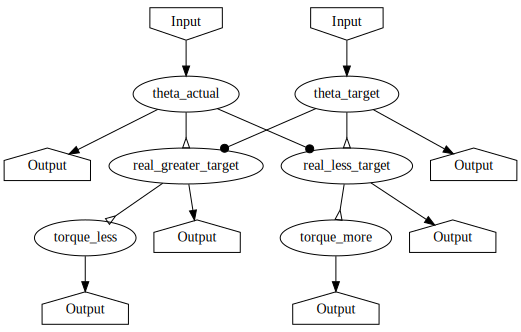

In [6]:
reversal_ex = 5.0
reversal_in = -2.0
reversal_mod = 0.0
nrn_nonspiking = NonSpikingNeuron()

net_angle = Network(name='Joint Angle Controller')

net_angle.add_neuron(nrn_nonspiking, name='theta_actual')
net_angle.add_neuron(nrn_nonspiking, name='theta_target')
net_angle.add_input('theta_actual')
net_angle.add_input('theta_target')
net_angle.add_output('theta_actual')
net_angle.add_output('theta_target')

net_angle.add_neuron(nrn_nonspiking, name='real_greater_target')
net_angle.add_neuron(nrn_nonspiking, name='real_less_target')
net_angle.add_output('real_greater_target')
net_angle.add_output('real_less_target')
g_add = 1/(reversal_ex-1)
g_sub = -(g_add*reversal_ex)/reversal_in
syn_add = NonSpikingSynapse(max_conductance=g_add, reversal_potential=reversal_ex, e_lo=0.0, e_hi=1.0)
syn_sub = NonSpikingSynapse(max_conductance=g_sub, reversal_potential=reversal_in, e_lo=0.0, e_hi=1.0)
net_angle.add_connection(syn_add, 'theta_actual', 'real_greater_target')
net_angle.add_connection(syn_sub, 'theta_target', 'real_greater_target')
net_angle.add_connection(syn_sub, 'theta_actual', 'real_less_target')
net_angle.add_connection(syn_add, 'theta_target', 'real_less_target')

net_angle.add_neuron(nrn_nonspiking, name='torque_more')
net_angle.add_neuron(nrn_nonspiking, name='torque_less')
k_more = 0.5
k_less = 0.5
g_torque_more = k_more/(reversal_ex-k_more)
g_torque_less = k_less/(reversal_ex-k_less)
syn_torque_more = NonSpikingSynapse(max_conductance=g_torque_more, reversal_potential=reversal_ex, e_lo=0.0, e_hi=1.0)
syn_torque_less = NonSpikingSynapse(max_conductance=g_torque_less, reversal_potential=reversal_ex, e_lo=0.0, e_hi=1.0)
net_angle.add_connection(syn_torque_more,'real_greater_target', 'torque_less')
net_angle.add_connection(syn_torque_less,'real_less_target', 'torque_more')
net_angle.add_output('torque_more')
net_angle.add_output('torque_less')

render(net_angle)

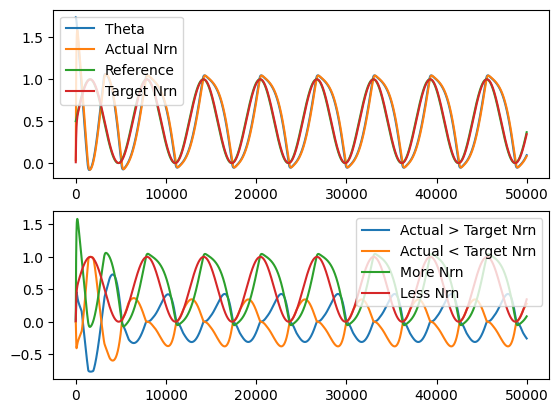

In [7]:
sns_angle = net_angle.compile(dt=0.1, backend='numpy')
model.opt.timestep = 0.0001
framerate = 60 # fps
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
dir = 1
inputs = np.zeros(2)
torque = 0
ref = []
num_steps = 50000
output = np.zeros([num_steps, 6])
theta = []
while i<num_steps:
  step_start = time.time()
  ref_angle = 0.5*np.sin(0.001*i)+0.5
  ref.append(ref_angle)
  #print(ref_angle)

  # mj_step can be replaced with code that also evaluates
  # a policy and applies a control signal before stepping the physics.
  if i % 100 == 0:
    dir *= -1
  data.ctrl[motor_ids_hip] = -1
  data.ctrl[motor_ids_knee] = -1
  data.ctrl[motor_ids_knee[0]] = torque

  mujoco.mj_step(model, data)

  angles_hip = data.qpos[hip_angles]
  angles_hip_map = remap(angles_hip, angles_hip_lower, angles_hip_upper)
  angles_knee = data.qpos[knee_angles]
  angles_knee_map = remap(angles_knee, angles_knee_lower, angles_knee_upper)

  inputs[0] = angles_knee_map[0]
  inputs[1] = ref_angle
  output[i,:] = sns_angle(inputs)
  theta.append(inputs[0])
  torque = output[i,4] - output[i,5]

#     print(torque)
#     # print('Hip Angles:')
#     # print(angles_hip_map)
#     # print('Knee Angles:')
#     # print(angles_knee_map)
#     # print('Sensor Readings:')
#     # print(data.sensordata)
#
  # Pick up changes to the physics state, apply perturbations, update options from GUI.
  if len(frames) < data.time * framerate:
    render_mj.update_scene(data)
    pixels = render_mj.render()
    frames.append(pixels)

  # Rudimentary time keeping, will drift relative to wall clock.
  # time_until_next_step = model.opt.timestep - (time.time() - step_start)
  # if time_until_next_step > 0:
  #   time.sleep(time_until_next_step)
  i += 1
output = output.transpose()
plt.figure()
plt.subplot(2,1,1)
plt.plot(theta, label='Theta')
plt.plot(output[0,:], label='Actual Nrn')
plt.plot(ref, label='Reference')
plt.plot(output[1,:], label='Target Nrn')
plt.legend()
plt.subplot(2,1,2)
plt.plot(output[2,:], label='Actual > Target Nrn')
plt.plot(output[3,:], label='Actual < Target Nrn')
plt.plot(output[0,:], label='More Nrn')
plt.plot(output[1,:], label='Less Nrn')
plt.legend()

media.show_video(frames, fps=framerate)

Next, we need to add some neurons to generate rythmic commands for the angle controller. Let's make a small network of neurons which oscillates, also known as a central pattern generator (CPG).

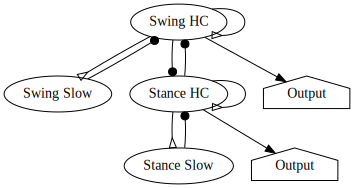

In [8]:
def add_cpg(net, suffix, start_swing=True):
    if start_swing:
        swing_initial = 0.5
        stance_initial = 0.0
    else:
        swing_initial = 0.0
        stance_initial = 0.5
    hc_bias = 0.1
    nrn_hc = NonSpikingNeuron(bias=hc_bias)
    nrn_slow = NonSpikingNeuron(membrane_capacitance=100)
    net.add_neuron(nrn_hc, name='Swing HC'+suffix, initial_value=swing_initial)
    net.add_neuron(nrn_slow, name='Swing Slow'+suffix)
    net.add_neuron(nrn_hc, name='Stance HC'+suffix, initial_value=stance_initial)
    net.add_neuron(nrn_slow, name='Stance Slow'+suffix)

    g_self = 0.5
    a = 0.9
    g_sf = (g_self * (reversal_ex - a) - a) / (a - reversal_in)
    syn_cpg_self = NonSpikingSynapse(max_conductance=g_self, reversal_potential=reversal_ex, e_hi=1)
    syn_cpg_ex_slow = NonSpikingSynapse(max_conductance=1 / (reversal_ex - 1), reversal_potential=reversal_ex, e_hi=1)
    syn_cpg_slow_in = NonSpikingSynapse(max_conductance=g_sf, reversal_potential=reversal_in, e_hi=1)
    g_in_hc = -hc_bias / reversal_in
    syn_cpg_hc = NonSpikingSynapse(max_conductance=g_in_hc, reversal_potential=reversal_in, e_hi=1)

    net.add_connection(syn_cpg_self, 'Swing HC'+suffix, 'Swing HC'+suffix)
    net.add_connection(syn_cpg_ex_slow, 'Swing HC'+suffix, 'Swing Slow'+suffix)
    net.add_connection(syn_cpg_slow_in, 'Swing Slow'+suffix, 'Swing HC'+suffix)
    net.add_connection(syn_cpg_self, 'Stance HC'+suffix, 'Stance HC'+suffix)
    net.add_connection(syn_cpg_ex_slow, 'Stance HC'+suffix, 'Stance Slow'+suffix)
    net.add_connection(syn_cpg_slow_in, 'Stance Slow'+suffix, 'Stance HC'+suffix)
    net.add_connection(syn_cpg_hc, 'Swing HC'+suffix, 'Stance HC'+suffix)
    net.add_connection(syn_cpg_hc, 'Stance HC'+suffix, 'Swing HC'+suffix)

net_cpg = Network(name='CPG Joint Controller')
add_cpg(net_cpg, '')
net_cpg.add_output('Swing HC')
net_cpg.add_output('Stance HC')

render(net_cpg)

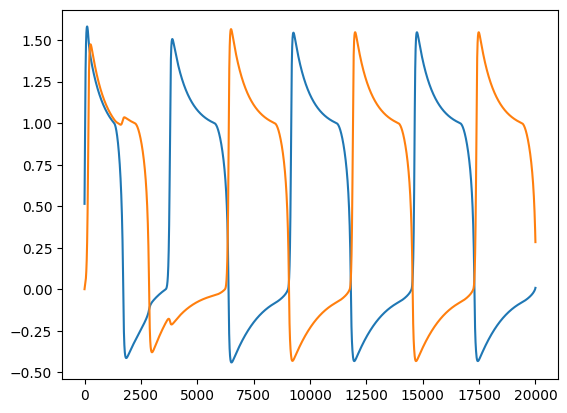

In [9]:
sns_cpg = net_cpg.compile(dt=0.1, backend='numpy')
num_steps = 20000
outputs = np.zeros([num_steps, 2])
for i in range(num_steps):
    outputs[i,:] = sns_cpg()
outputs = outputs.transpose()
plt.figure()
plt.plot(outputs[0,:])
plt.plot(outputs[1,:])

Now that we have a controller for a single joint, let's generate a controller for one leg. Each joint (hip, knee) has a cpg and an angle controller, and we link the two cpg networks so that they operate synchronously.

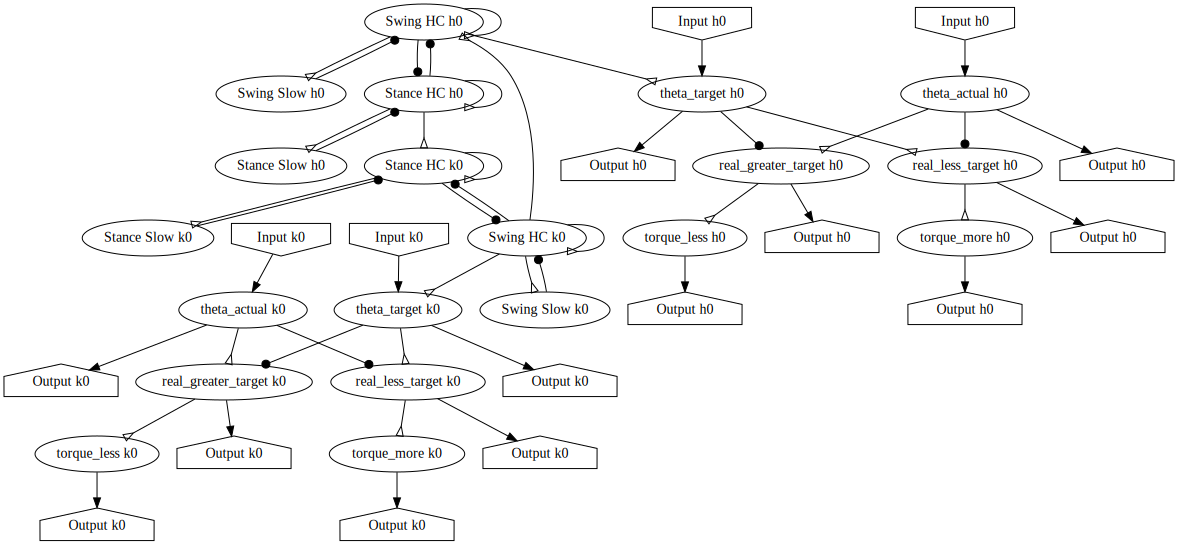

In [10]:
def add_leg(net, suffix, start_swing):
    add_cpg(net, ' h'+suffix, start_swing=start_swing)
    net.add_network(net_angle, suffix=' h'+suffix)
    add_cpg(net, ' k'+suffix, start_swing=start_swing)
    net.add_network(net_angle, suffix=' k'+suffix)
    # net.add_input('Swing HC k')
    net.add_connection(syn_add, 'Swing HC h'+suffix, 'theta_target h'+suffix)
    net.add_connection(syn_add, 'Swing HC k'+suffix, 'theta_target k'+suffix)
    net.add_connection(syn_add, 'Swing HC k'+suffix, 'Swing HC h'+suffix)
    net.add_connection(syn_add, 'Stance HC h'+suffix, 'Stance HC k'+suffix)
    # net.add_output('Swing HC h'+suffix)
    # net.add_output('Stance HC h'+suffix)
    # net.add_output('Swing HC k'+suffix)
    # net.add_output('Stance HC k'+suffix)


net_leg = Network(name='Leg Controller')
add_leg(net_leg, '0', True)
render(net_leg)

In [21]:
sns_leg = net_leg.compile(dt=0.1, backend='numpy')
model.opt.timestep = 0.0001
framerate = 60 # fps
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
dir = 1
inputs = np.zeros(4)
torque_knee = 0
torque_hip = 0
ref = []
num_steps = 20000
output = np.zeros([num_steps, 12])
theta = []
while i<num_steps:
  step_start = time.time()
  ref_angle = 0.5*np.sin(0.001*i)+0.5
  ref.append(ref_angle)
  #print(ref_angle)

  # mj_step can be replaced with code that also evaluates
  # a policy and applies a control signal before stepping the physics.

  data.ctrl[motor_ids_hip] = -1
  data.ctrl[motor_ids_knee] = -1
  data.ctrl[motor_ids_knee[0]] = torque_knee
  data.ctrl[motor_ids_hip[0]] = torque_hip

  mujoco.mj_step(model, data)

  angles_hip = data.qpos[hip_angles]
  angles_hip_map = remap(angles_hip, angles_hip_lower, angles_hip_upper)
  angles_knee = data.qpos[knee_angles]
  angles_knee_map = remap(angles_knee, angles_knee_lower, angles_knee_upper)

  inputs[0] = angles_hip_map[0]
  inputs[1] = 0
  inputs[2] = angles_knee_map[0]

  output[i,:] = sns_leg(inputs)
  theta.append(inputs[0])
  torque_hip = output[i,4] - output[i,5]
  torque_knee = output[i,10] - output[i,11]

#     print(torque)
#     # print('Hip Angles:')
#     # print(angles_hip_map)
#     # print('Knee Angles:')
#     # print(angles_knee_map)
#     # print('Sensor Readings:')
#     # print(data.sensordata)
#
  # Pick up changes to the physics state, apply perturbations, update options from GUI.
  if len(frames) < data.time * framerate:
    render_mj.update_scene(data)
    pixels = render_mj.render()
    frames.append(pixels)
  i += 1

media.show_video(frames, fps=framerate)

Finally, let's generate locomotion. We'll do it simply here, where each leg has the same control structure and we just initialize the legs such that they alternate in a tripod configuration. This is just a tutorial, in actual animals there are connective pathways between the legs that generate and coordinate gaits.

In [24]:
net_walk = Network(name='Walking Controller')
add_leg(net_walk, '0', True)
add_leg(net_walk, '1', False)
add_leg(net_walk, '2', True)
add_leg(net_walk, '3', False)
add_leg(net_walk, '4', True)
add_leg(net_walk, '5', False)

framerate = 60 # fps
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
sns_walk = net_walk.compile(dt=0.1, backend='numpy')
model.opt.timestep = 0.0001
i = 0
inputs = np.zeros(4*6)
torque_knee = np.zeros(6)-1
torque_hip = np.zeros(6)-1
num_steps = 50000
output = np.zeros([num_steps, 12*6])
while i < num_steps:
  data.ctrl[motor_ids_hip] = torque_hip
  data.ctrl[motor_ids_knee] = torque_knee

  mujoco.mj_step(model, data)

  angles_hip = data.qpos[hip_angles]
  angles_hip_map = remap(angles_hip, angles_hip_lower, angles_hip_upper)
  angles_knee = data.qpos[knee_angles]
  angles_knee_map = remap(angles_knee, angles_knee_lower, angles_knee_upper)

  inputs[0::4] = angles_hip_map
  inputs[2::4] = angles_knee_map
  output[i,:] = sns_walk(inputs)
  torque_hip = output[i,4::12] - output[i,5::12]
  torque_knee = output[i,10::12] - output[i,11::12]

  if len(frames) < data.time * framerate:
    render_mj.update_scene(data)
    pixels = render_mj.render()
    frames.append(pixels)
  i += 1

media.show_video(frames, fps=framerate)

# SNSTorch
So far we have been using SNS-Toolbox, which simulates generally one large recurrent population. This works for moderate-scale networks, but as we increase the network size we get N^2 matrices... which is bad. For larger networks, we are developing SNSTorch. SNSTorch is still in early development, but we can train networks of non-spiking neurons with conductance-based synapses. Here, we will demonstrate this by training a recurrent SNS to classify the row-wise sequential MNIST dataset.

In [2]:
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import snstorch.modules as m
import pickle
from tqdm import tqdm
from datetime import datetime

In [3]:
BATCH_SIZE = 64

# download and load training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
# parameters
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 128
N_OUTPUTS = 10
N_EPOCHS = 10

class ImageSNS(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageSNS, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.input = nn.Linear(self.n_inputs, self.n_neurons)
        self.hidden = m.NonSpikingLayer(self.n_neurons)
        self.h2h = m.NonSpikingChemicalSynapseLinear(self.n_neurons, self.n_neurons)
        # self.h2h = nn.Linear(self.n_neurons, self.n_neurons)
        self.out = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self, size):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(size, self.n_neurons, device=device))

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        self.batch_size = X.size(1)

        # rnn_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each rnn_out)
        for i in range(N_STEPS):
            ext = self.input(X[i,:,:])
            prev = self.h2h(self.state, self.state)
            # prev = self.h2h(self.state)
            self.state = self.hidden(ext+prev, self.state)
            # print(ext+prev)
        out = self.out(self.state)
        # print(out)
        return out.view(-1, self.n_outputs)  # batch_size X n_output

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()


In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImageSNS(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

test_acc = 0.0
test_acc_last = -1.0
loss_history = []
acc_train_history = []
acc_test_history = []
# for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
epoch = 0
r = 0
while test_acc > test_acc_last or epoch <= N_EPOCHS:
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(tqdm(trainloader)):
        # print(i)
        # zero the parameter gradients
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 28, 28)

        batch_size = inputs.size(0)
        # reset hidden states
        model.state = model.init_hidden(batch_size)
        model.h2h.setup()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print('Run: %i | Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          % (r, epoch, train_running_loss / i, train_acc / i))
    loss_history.extend([train_running_loss/i])
    acc_train_history.extend([train_acc/i])
    test_acc_last = test_acc
    test_acc = 0.0
    model.h2h.setup()
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 28, 28)
        batch_size = inputs.size(0)
        model.state = model.init_hidden(batch_size)

        outputs = model(inputs)

        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    acc_test_history.extend([test_acc/i])
    epoch += 1

    print('Test Accuracy: %.2f' % (test_acc / i))

plt.figure()
plt.subplot(2,1,1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.subplot(2,1,2)
plt.plot(acc_train_history, label='Training Accuracy')
plt.plot(acc_test_history, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 938/938 [02:02<00:00,  7.64it/s]

Run: 0 | Epoch:  0 | Loss: 1.3904 | Train Accuracy: 54.35


Test Accuracy: 69.30


100%|██████████| 938/938 [01:53<00:00,  8.30it/s]

Run: 0 | Epoch:  1 | Loss: 0.8746 | Train Accuracy: 72.23


Test Accuracy: 75.40


100%|██████████| 938/938 [01:48<00:00,  8.62it/s]

Run: 0 | Epoch:  2 | Loss: 0.6882 | Train Accuracy: 78.24


Test Accuracy: 81.35


100%|██████████| 938/938 [02:02<00:00,  7.68it/s]

Run: 0 | Epoch:  3 | Loss: 0.5592 | Train Accuracy: 82.11


Test Accuracy: 83.62


100%|██████████| 938/938 [01:54<00:00,  8.17it/s]

Run: 0 | Epoch:  4 | Loss: 0.4861 | Train Accuracy: 84.61


Test Accuracy: 85.99


100%|██████████| 938/938 [02:04<00:00,  7.53it/s]

Run: 0 | Epoch:  5 | Loss: 0.4399 | Train Accuracy: 85.98


Test Accuracy: 86.05


100%|██████████| 938/938 [02:02<00:00,  7.68it/s]

Run: 0 | Epoch:  6 | Loss: 0.4025 | Train Accuracy: 87.42


Test Accuracy: 88.62


100%|██████████| 938/938 [02:20<00:00,  6.68it/s]

Run: 0 | Epoch:  7 | Loss: 0.3761 | Train Accuracy: 88.10


Test Accuracy: 88.13


100%|██████████| 938/938 [02:24<00:00,  6.48it/s]

Run: 0 | Epoch:  8 | Loss: 0.3486 | Train Accuracy: 89.00


Test Accuracy: 89.32


100%|██████████| 938/938 [02:31<00:00,  6.21it/s]

Run: 0 | Epoch:  9 | Loss: 0.3281 | Train Accuracy: 89.70


Test Accuracy: 90.69


100%|██████████| 938/938 [02:33<00:00,  6.11it/s]

Run: 0 | Epoch:  10 | Loss: 0.3139 | Train Accuracy: 90.02


Test Accuracy: 90.99


100%|██████████| 938/938 [02:00<00:00,  7.75it/s]

Run: 0 | Epoch:  11 | Loss: 0.2994 | Train Accuracy: 90.53


Test Accuracy: 89.95


 56%|█████▌    | 526/938 [01:17<00:53,  7.69it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 56%|█████▌    | 526/938 [01:17<01:00,  6.81it/s]


KeyboardInterrupt: 